## *Classification Problem*

 This classification model help to predict whether or not a customer will purchase a bike. The model then predict bike purchasing for new customers for whom no information about average monthly spend or previous bike purchases is available.

In [1]:
#Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
import datetime as dt
import matplotlib.style as style
# Use a clean stylizatino for our charts and graphs
style.use('fivethirtyeight')

In [2]:
import warnings  # to ignore seaborn warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn

In [3]:
#reading the data
train=pd.read_csv("AdvWorksCusts.csv")
ave_spend=pd.read_csv("AW_AveMonthSpend.csv")
bike_buyer=pd.read_csv('AW_BikeBuyer.csv')
test=pd.read_csv('AW_test.csv')

In [4]:
#Checking the head of the data to have an overview of the data
train.head()

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
0,11000,NaN,Jon,V,Yang,NaN,3761 N. 14th St,NaN,Rockhampton,Queensland,...,1966-04-08,Bachelors,Professional,M,M,1,0,0,2,137947
1,11001,NaN,Eugene,L,Huang,NaN,2243 W St.,NaN,Seaford,Victoria,...,1965-05-14,Bachelors,Professional,M,S,0,1,3,3,101141
2,11002,NaN,Ruben,NaN,Torres,NaN,5844 Linden Land,NaN,Hobart,Tasmania,...,1965-08-12,Bachelors,Professional,M,M,1,1,3,3,91945
3,11003,NaN,Christy,NaN,Zhu,NaN,1825 Village Pl.,NaN,North Ryde,New South Wales,...,1968-02-15,Bachelors,Professional,F,S,0,1,0,0,86688
4,11004,NaN,Elizabeth,NaN,Johnson,NaN,7553 Harness Circle,NaN,Wollongong,New South Wales,...,1968-08-08,Bachelors,Professional,F,S,1,4,5,5,92771


## Step1 : Performing basic Data Preprocessing 
Data Preprocessing to be done include;

1. Checking for `Duplicates`
2. Checking for `Missing Values`
3. Exploratory Data Analysis to gain insights from the data
4. Feature Engineering
5. Label Encoding of Categorical Variable

In [5]:
#------------------1. Checking for Duplicates----------------------------------------
print(train.shape)

print (train['CustomerID'].unique().shape)

print(bike_buyer.shape)

(16519, 23)
(16404,)
(16519, 2)


In [6]:
#Merging the target variable data with the other features
print('Shape before merging Data:', train.shape)
train=pd.merge(train,bike_buyer,how='inner', on='CustomerID')
print('Shape After merging Data:', train.shape)

Shape before merging Data: (16519, 23)
Shape After merging Data: (16749, 24)


In [7]:
#Dropping Duplicates row in the data using the unique customerID feature
train.drop_duplicates('CustomerID',keep='first',inplace=True)

In [8]:
#Performing same process on the test data
test.drop_duplicates('CustomerID',keep='first',inplace=True)

In [9]:
#Checking that both test and train have equal row and column and duplicates removed
print(train.shape)
print()

print (train['CustomerID'].unique().shape)

print()

print(test.shape)

print (test['CustomerID'].unique().shape)

(16404, 24)

(16404,)

(500, 23)
(500,)


In [264]:
#----------------------2. Checking for Missing Value----------------------------

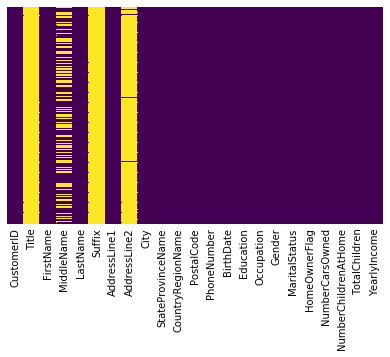

In [10]:
sns.heatmap(test.isnull(),cbar=False, cmap='viridis',yticklabels=False)

From the heatmap above, we see that on the Title, MiddleName, Suffix and AddressLine has missing  values and since they don't have significant impact on the target variable it would be dropped.

In [11]:
test.drop(labels = ['Title','MiddleName','Suffix','AddressLine2'], axis = 1, inplace = True)
train.drop(labels = ['Title','MiddleName','Suffix','AddressLine2'], axis = 1, inplace = True)

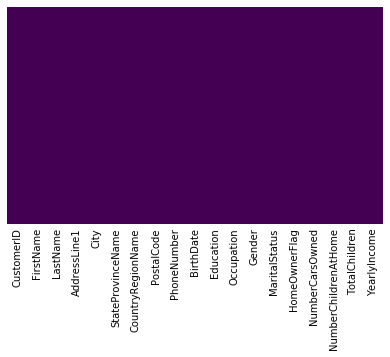

In [12]:
#Checking to see if the missing column has been dropped
sns.heatmap(test.isnull(),cbar=False, cmap='viridis',yticklabels=False)

In [13]:
#Creating a function to extract the age of each person from their Date of Birth to when the data was collected
def Age(DOB):
    Date = dt.date(1998,1,1).year  # where Date is the date the data was collected given as 1998-01-01
    Year = DOB.split('-')[0]
    Age = Date - int(Year)
    return Age

In [14]:
def Age_test(DOB):
    Date = dt.date(1998,1,1).year  # where Date is the date the data was collected given as 1998-01-01
    Year = DOB.split('/')[-1]
    Age = Date - int(Year)
    return Age

In [15]:
#Creating another feature called 'Age' from the 'BirthDate' 

train['Age'] = train['BirthDate'].apply(lambda x : Age(x))

In [17]:
#Checking the percentage of people who bought the bike and those who do not 
train['BikeBuyer'].value_counts(normalize=True)

0    0.667703
1    0.332297
Name: BikeBuyer, dtype: float64

We see that more people didnot purchase the bike

In [18]:
#Performing same process done on the training data on the test data
test['Age'] = test['BirthDate'].apply(lambda x : Age_test(x))

In [19]:
test.head()

,CustomerID,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Age
0,18988,Courtney,Baker,8727 Buena Vista Ave.,Fremont,California,United States,94536,133-555-0128,1/5/1945,Bachelors,Management,F,S,0,2,0,5,86931,53
1,29135,Adam,Allen,3491 Cook Street,Haney,British Columbia,Canada,V2W 1W2,252-555-0173,10/4/1964,Bachelors,Skilled Manual,M,M,1,2,2,4,100125,34
2,12156,Bonnie,Raji,359 Pleasant Hill Rd,Burbank,California,United States,91502,409-555-0193,1/12/1934,Graduate Degree,Management,F,M,1,2,0,4,103985,64
3,13749,Julio,Alonso,8945 Euclid Ave.,Burlingame,California,United States,94010,175-555-0196,9/22/1958,Graduate Degree,Skilled Manual,M,M,1,0,0,4,127161,40
4,27780,Christy,Andersen,"42, boulevard Tremblay",Dunkerque,Nord,France,59140,1 (11) 500 555-0122,3/19/1965,High School,Manual,F,M,1,1,2,2,21876,33


In [20]:
#Checking the datatypes of our features
train.dtypes

CustomerID               int64
FirstName               object
LastName                object
AddressLine1            object
City                    object
StateProvinceName       object
CountryRegionName       object
PostalCode              object
PhoneNumber             object
BirthDate               object
Education               object
Occupation              object
Gender                  object
MaritalStatus           object
HomeOwnerFlag            int64
NumberCarsOwned          int64
NumberChildrenAtHome     int64
TotalChildren            int64
YearlyIncome             int64
BikeBuyer                int64
Age                      int64
dtype: object

In [21]:
#Dropping the BirthDate feature since we have extracted the information we need from it and other feature that won't have significant impact on the target variable
train.drop(labels = ['FirstName','LastName','BirthDate'], axis = 1, inplace = True)
test.drop(labels = ['FirstName','LastName','BirthDate'], axis = 1, inplace = True)

In [22]:
train.drop(labels = ['AddressLine1','PostalCode','PhoneNumber','City','CustomerID'], axis = 1, inplace = True)
test.drop(labels = ['AddressLine1','PostalCode','PhoneNumber','City','CustomerID'], axis = 1, inplace = True)

In [23]:
test.drop(labels = ['StateProvinceName'], axis = 1, inplace = True)

In [24]:
train.drop(labels = ['StateProvinceName'], axis = 1, inplace = True)

In [25]:
#Checking the head of our data after dropping all[ the features that won't have significant impact on the target variable
train.head()

,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age
0,Australia,Bachelors,Professional,M,M,1,0,0,2,137947,0,32
1,Australia,Bachelors,Professional,M,S,0,1,3,3,101141,1,33
2,Australia,Bachelors,Professional,M,M,1,1,3,3,91945,0,33
3,Australia,Bachelors,Professional,F,S,0,1,0,0,86688,0,30
4,Australia,Bachelors,Professional,F,S,1,4,5,5,92771,1,30


In [26]:
#----------------------------------3. EXPLORATORY DATA ANALYSIS-------------------------------

#This is done to have an insights about the data

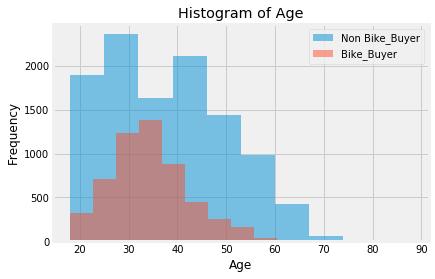

In [27]:
# get a histogram of the Age column for those both the Bike and those who donot

col = 'Age'
plt.hist(train[train['BikeBuyer']==0][col], 10, alpha=0.5, label='Non Bike_Buyer')
plt.hist(train[train['BikeBuyer']==1][col], 10, alpha=0.5, label='Bike_Buyer')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

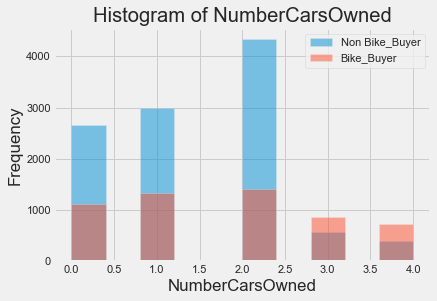

In [173]:
col = 'NumberCarsOwned'
plt.hist(train[train['BikeBuyer']==0][col], 10, alpha=0.5, label='Non Bike_Buyer')
plt.hist(train[train['BikeBuyer']==1][col], 10, alpha=0.5, label='Bike_Buyer')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

C:\Users\Opeyemi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


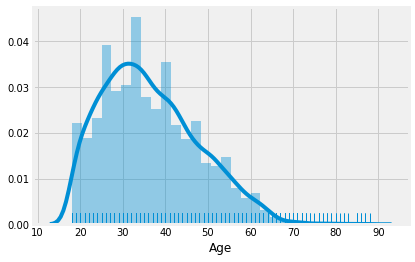

In [28]:
sns.distplot(train['Age'],bins=30, rug=True)

We see that the distribution of the Age in the data is Rightly skewed which would need to be normalized so as to enable our model to perform optimally

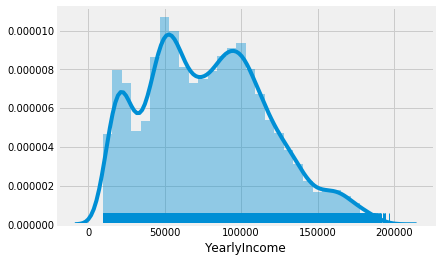

In [29]:
#Performing Visualization on the Yearly Income
sns.distplot(train['YearlyIncome'],bins=30, rug=True)

Similarly, the distribution plot of the Yearly income is bi-modal and also not normalized so normalization would be performed on it as shown below for both the testing and training data

In [30]:
train['Age']=np.log(train['Age'])
train['YearlyIncome']=(train['YearlyIncome'])**0.5
test['Age']=np.log(test['Age'])
test['YearlyIncome']=(test['YearlyIncome'])**0.5

In [176]:
train.head()

,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age
0,Australia,Bachelors,Professional,M,M,1,0,0,2,371.412170,0,3.465736
1,Australia,Bachelors,Professional,M,S,0,1,3,3,318.026728,1,3.496508
2,Australia,Bachelors,Professional,M,M,1,1,3,3,303.224339,0,3.496508
3,Australia,Bachelors,Professional,F,S,0,1,0,0,294.428260,0,3.401197
4,Australia,Bachelors,Professional,F,S,1,4,5,5,304.583322,1,3.401197


In [32]:
#Checking Pearson's correlation of each feature on the Target variable to know which feature is highly correlated or not
train.corr()['BikeBuyer']

HomeOwnerFlag           0.000127
NumberCarsOwned         0.164835
NumberChildrenAtHome    0.455930
TotalChildren           0.233594
YearlyIncome            0.273008
BikeBuyer               1.000000
Age                    -0.093858
Name: BikeBuyer, dtype: float64

From above , we see that the `Number of Children at home` has the highest correlation with the target variable which is positive which implies that the higher the number of children a person have at home, the higher the probability and likelihood of buying a bike and vice versa.

Also, we see that `HomeOwnerFlag` has a very very weak correlation on the `target` . 

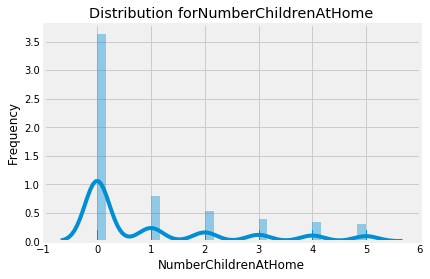

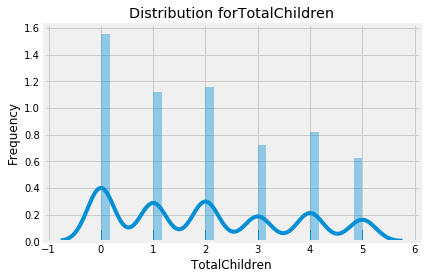

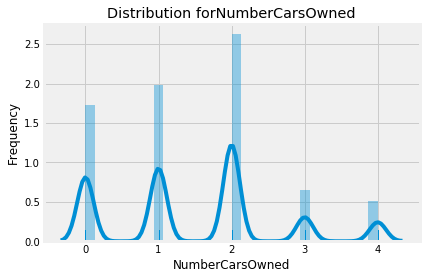

In [33]:
column=['NumberChildrenAtHome','TotalChildren','NumberCarsOwned']
def distplot(df, column, bins = 30, hist = False):
    for col in column:
        sns.distplot(df[col], bins=bins, rug=True, hist=hist)
        plt.title('Distribution for' + col)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

distplot(train, column, hist= True)

From the distributions shown above , we can see that there is a distinction between those that have `0 Children` and those that have `Children` that is `1, 2,3 & 4`, so we can engineer new feature from here to separate those that have children and those that don't.

Similarly,from the distribution of the `Number of Cars Owned`, we see that there seem to be a distinction between those that have `2 cars that is those with 3 & 4 cars` and those with `1 or 2 cars ` and those with `0 cars`. This insights would help to engineer new feature which would classify those with `0 cars, >=1 cars, >=3 cars`.

The steps below shows how  the features are created

In [47]:
#----------------------------------------4. FEATURE ENGINEERING--------------------------------------------

In [35]:
def Numberchildren(n):
    if n>0:
        return 'More than 1'
    else:
        return 'No Children'

In [36]:
train['NumberChildrenAtHome'] = train['NumberChildrenAtHome'].apply(lambda x: Numberchildren(x))

In [37]:
test['NumberChildrenAtHome'] = test['NumberChildrenAtHome'].apply(lambda x: Numberchildren(x))

In [38]:
train['TotalChildren'] = train['TotalChildren'].apply(lambda x: Numberchildren(x))
test['TotalChildren'] = test['TotalChildren'].apply(lambda x: Numberchildren(x))

In [39]:
train.head()

,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age
0,Australia,Bachelors,Professional,M,M,1,0,No Children,More than 1,371.412170,0,3.465736
1,Australia,Bachelors,Professional,M,S,0,1,More than 1,More than 1,318.026728,1,3.496508
2,Australia,Bachelors,Professional,M,M,1,1,More than 1,More than 1,303.224339,0,3.496508
3,Australia,Bachelors,Professional,F,S,0,1,No Children,No Children,294.428260,0,3.401197
4,Australia,Bachelors,Professional,F,S,1,4,More than 1,More than 1,304.583322,1,3.401197


In [40]:
def NumberCars(n):
    if n == 0:
        return 'No car'
    elif n>0 and n<3:
        return '>1 cars'
    
    else:
        return '>3 cars'

In [41]:
train['NumberCarsOwned'] = train['NumberCarsOwned'].apply(lambda x: NumberCars(x))
test['NumberCarsOwned'] = test['NumberCarsOwned'].apply(lambda x: NumberCars(x))

In [42]:
train.head()

,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age
0,Australia,Bachelors,Professional,M,M,1,No car,No Children,More than 1,371.412170,0,3.465736
1,Australia,Bachelors,Professional,M,S,0,>1 cars,More than 1,More than 1,318.026728,1,3.496508
2,Australia,Bachelors,Professional,M,M,1,>1 cars,More than 1,More than 1,303.224339,0,3.496508
3,Australia,Bachelors,Professional,F,S,0,>1 cars,No Children,No Children,294.428260,0,3.401197
4,Australia,Bachelors,Professional,F,S,1,>3 cars,More than 1,More than 1,304.583322,1,3.401197


In [43]:
train.corr()['BikeBuyer']

HomeOwnerFlag    0.000127
YearlyIncome     0.273008
BikeBuyer        1.000000
Age             -0.093858
Name: BikeBuyer, dtype: float64

In [44]:
#Dropping the HomeOwnerFlag feature since it has very little or no impact on our target variable
train.drop(labels = ['HomeOwnerFlag'], axis = 1, inplace = True)
test.drop(labels = ['HomeOwnerFlag'], axis = 1, inplace = True)

In [45]:
train.head()

,CountryRegionName,Education,Occupation,Gender,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age
0,Australia,Bachelors,Professional,M,M,No car,No Children,More than 1,371.412170,0,3.465736
1,Australia,Bachelors,Professional,M,S,>1 cars,More than 1,More than 1,318.026728,1,3.496508
2,Australia,Bachelors,Professional,M,M,>1 cars,More than 1,More than 1,303.224339,0,3.496508
3,Australia,Bachelors,Professional,F,S,>1 cars,No Children,No Children,294.428260,0,3.401197
4,Australia,Bachelors,Professional,F,S,>3 cars,More than 1,More than 1,304.583322,1,3.401197


In [46]:
#Checking the Categorical feature in our data
print(test['CountryRegionName'].value_counts())


United States     225
Australia          86
Germany            49
Canada             49
France             47
United Kingdom     44
Name: CountryRegionName, dtype: int64


-------------------5. *LABEL ENCODING*---------------------------------------------------

This process is done to convert the Categorical features to numerical variables that the algorithm can understand 

In [48]:
columns=['CountryRegionName', 'Education', 'Occupation', 'Gender',
       'MaritalStatus', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'TotalChildren']

In [49]:
train=pd.get_dummies(train, columns=columns,drop_first=True)
test=pd.get_dummies(test, columns=columns, drop_first=True)

In [51]:
#Checking to see if the categorical features has been converted 
train.head()

,YearlyIncome,BikeBuyer,Age,CountryRegionName_Canada,CountryRegionName_France,CountryRegionName_Germany,CountryRegionName_United Kingdom,CountryRegionName_United States,Education_Graduate Degree,Education_High School,...,Occupation_Management,Occupation_Manual,Occupation_Professional,Occupation_Skilled Manual,Gender_M,MaritalStatus_S,NumberCarsOwned_>3 cars,NumberCarsOwned_No car,NumberChildrenAtHome_No Children,TotalChildren_No Children
0,371.412170,0,3.465736,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
1,318.026728,1,3.496508,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
2,303.224339,0,3.496508,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,294.428260,0,3.401197,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
4,304.583322,1,3.401197,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [52]:
print('Shape of train', train.shape)
print('Shape of test', test.shape)


Shape of train (16404, 22)
Shape of test (500, 21)


### Step 2 : Model Creation and Evaluation 

This stage involve performing necessary algorithm for our Model to learn from the data and evaluating it performances. The process includes;

1. Using GridSearch to determine the Best algorithm and parameters that performs to be used on the data
2. Use evalution metrics to check algorithm and their performances
3. Predicting our test data

In [53]:
from sklearn.model_selection import GridSearchCV
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print ("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print ("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print ("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print ("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
    
    print ('Best parameter.{}'.format(grid.best_estimator_))

In [54]:
# Import four machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Set up some parameters for our grid search
# We will start with four different machine learning models
# logistic regression, KNN, Decision Tree, and Random Forest
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}
tree_params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
forest_params = {'n_estimators': [10, 50, 100,110], 'max_depth': [None, 1, 3, 5, 7]}
knn_params = {'n_neighbors': [1, 3, 5, 7]}


# instantiate the four machine learning models
lr = LogisticRegression()
knn = KNeighborsClassifier()
d_tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

In [55]:
#Import Sklearn train test split library to help us split our data before different algorithm are used on the data
from sklearn.model_selection import train_test_split

In [56]:
X = train.drop(['BikeBuyer'],axis=1)
y = train['BikeBuyer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [217]:
get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.7691416727627408
Best Parameters: {'C': 1.0, 'penalty': 'l1'}
Average Time to Fit (s): 0.613
Average Time to Score (s): 0.015


In [218]:
get_best_model_and_accuracy(d_tree, tree_params, X, y)

Best Accuracy: 0.7844428188246769
Best Parameters: {'max_depth': 7}
Average Time to Fit (s): 0.113
Average Time to Score (s): 0.007


In [235]:
get_best_model_and_accuracy(forest, forest_params, X, y)

Best Accuracy: 0.7890148744208729
Best Parameters: {'max_depth': 7, 'n_estimators': 50}
Average Time to Fit (s): 0.559
Average Time to Score (s): 0.067
Best parameter.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [236]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [238]:
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [240]:
prediction = model.predict(X_test)

In [241]:
from sklearn.metrics import classification_report, confusion_matrix

In [242]:
print(confusion_matrix(y_test,prediction))
print()
print(classification_report(y_test,prediction))

[[3060  275]
 [ 766  821]]

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3335
           1       0.75      0.52      0.61      1587

   micro avg       0.79      0.79      0.79      4922
   macro avg       0.77      0.72      0.73      4922
weighted avg       0.78      0.79      0.78      4922



In [249]:
solution = model.predict(test)

In [251]:
my_submission=pd.DataFrame({'BikeBuyer': solution})


In [254]:
my_submission.to_csv('RandomForestsolution.csv', index=False)

In [255]:
my_submission.shape

(500, 1)